---
title: |
  Soundscapy: A python package for soundscape assessment and analysis
authors: 
  - name: Andrew Mitchell
    email: "andrew.mitchell.18@ucl.ac.uk"
    affiliations: 
      - name: University College London
        department: Bartlett School of Sustainable Construction
        address: London, UK
abstract: |
  Soundscape questionnaires are widely used to gather subjective information about people's perceptions and attitudes towards their acoustic environment. Despite the widespread adoption of ISO/TS 12913-3 guidelines for analyzing soundscape survey data, there are still several misapplications and interpretations. A recent study has proposed an innovative visualization approach for soundscape data analysis, using a probabilistic method that depicts the collective perception of a soundscape as a distribution of responses within the circumplex. To bring this method to life, a new open-source python package called Soundscapy has been developed. The main goal of this software is to enable the easy, accessible, and consistent application of analysis for soundscape data collected according to the ISO 12913 methods. This conference paper outlines the important features of Soundscapy, explains its basic functioning, lists its current capabilities, and gives recommendations for its best use. Finally, the future development of Soundscapy is proposed, including the integration of psychoacoustic analysis, predictive soundscape models, and soundscape indices for use in automated assessment and design.
format:
  internoise-typst: 
    keep-typ: true
  # internoise-pdf: default
bib-typst: FellowshipRefs-biblatex.bib
# bibliography: FellowshipRefs-biblatex.bib
execute:
  cache: true
  keep-ipynb: true
---

In [1]:
#| include: false
import matplotlib.pyplot as plt
from pathlib import Path
import time
import pandas as pd
from soundscapy.analysis.parallel_processing import parallel_process
import warnings
warnings.filterwarnings("ignore")

__spec__ = None # solves an bug with multiprocessing

wav_dir = Path("data")

# Introduction

Since 2018, the ISO/TS 12913 series of standards has provided a framework for the measurement, analysis, and reporting of soundscape perception @ISO12913Part2 @ISO12913Part3. The standard outlines a structured approach to soundscape data collection, including the use of questionnaires, binaural recordings, and environmental measurements. While other software tools exist for conducting soundscape analysis (see @sec-psychoacoustic for some examples), these are typically targeted towards audio analysis in the vein of soundscape ecology, rather than the analysis of soundscape perception data. Soundscapy aims to enable the analysis of human perceptual data from soundscapes, following the definition of 'soundscape' given in ISO 12913-1 @ISO12913Part1. 

In addition to implementing analysis methods for questionnaire data, Soundscapy also provides tools for the analysis of binaural recordings in line with ISO 12913-3. This includes the calculation of acoustic indices, such as the sound pressure level (SPL) and psychoacoustic indices, such as the loudness level (N) and sharpness (S). This paper will provide an overview of these features as implemented in the current version (v0.6), how these improve over existing tools, and a discussion of the future development of Soundscapy.

# Background

In 2010, Axelsson, Nilsson, & Berglund @Axelsson2010principal proposed a *principal components* model of soundscape perception. Due to its similarity to the the widely-studied Russell's circumplex model of affect @Russell1980circumplex, Axelsson's principal component model is often referred to as the Soundscape Circumplex Model in soundscape literature. The circumplex model and the Swedish Soundscape Quality Protocol (SSQP) @Axelsson2012Swedish utilizing it quickly became the predominant method of soundscape assessment in both scientific literature and professional practice @Aletta2023Adoption, due to its ease of use, interpretability, and, crucially, its ability to summarise the complex interrelationships between soundscape descriptors within a straightforward and familiar two-dimensional space. Together with a similar principal component model in Cain et al. @Cain2013development, the framework of the circumplex model of soundscape perception was subsequently adapted into an integral part of the standardised data collection, specifically in Method A of ISO/TS 12913-2 @ISO12913Part2.

The soundscape circumplex model is composed of eight scales, which closely resemble the eight scales of the Circumplex Model of Affect @Russell1980circumplex. The 7 scales are arranged in two bipolar dimensions, with pleasant-annoying along the *x* axis (valence) and eventful-uneventful along the *y* axis (arousal), as shown in @fig-circumplex. 

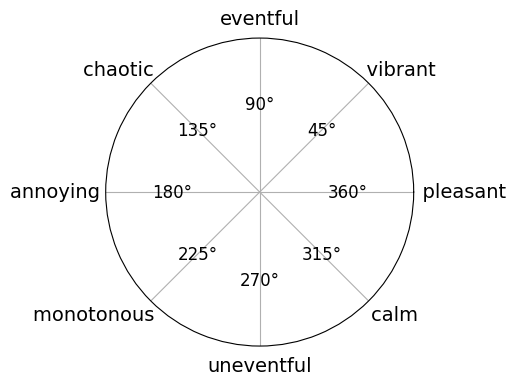

In [2]:
#| echo: false
#| fig-cap: The Soundscape Circumplex Model.
#| fig-align: center
#| label: fig-circumplex
#| include: true
import numpy as np
degree_sign = u'\N{DEGREE SIGN}'
angles = (90, 135, 180, 225, 270, 315, 360, 45)
alabel = (
    "eventful", "chaotic      ", "annoying          ", "monotonous              ", 
    "uneventful", "    calm", "          pleasant", "      vibrant")

# Create plot ---------------------------------------------------------------

fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))

ax.plot()
ax.set_xticks(np.radians(angles), labels=alabel, fontsize=14)
ax.set_yticks([])
ax.grid(True)
for i, angle in enumerate(angles):
    ax.text(
        np.radians(angle),
        0.6,
        f"{angle}{degree_sign}",
        ha="center",
        va="center",
        fontsize=12,
)
plt.show()


Currently, the soundscape community relies very heavily on the framework proposed in ISO/TS 12913-2, both for theory development and for procuring empirical evidence of the benefits of the soundscape approach in real life scenarios. In a recent literature review, Aletta & Torresin @Aletta2023Adoption identified 254 scientific publications which have referred to ISO 12913 since its publication in 2018, with 50 of them appropriately making use of the data collection methods. Of those, several papers included multiple studies, with 51 studies making use of the circumplex model as recommended in the ISO standard. In addition, the circumplex model has been used in many more studies without reference to the ISO standard @Engel2018Review.

However, there is currently no standardised software enabling the circumplex analysis recommended by the ISO 12913 standards. This can lead to inconsistencies, errors, and delays in the application of the recommendations. With the revision of ISO 12913 Part 3 currently underway and proposals for more advanced analysis methods being discussed, an easy-to-use and free tool is even more necessary to ensure the consistent and validated application of the standard.

In addition to the recommendations for the analysis of this questionnaire data, the ISO/TS 12913 series of standards also provides a framework for the analysis of binaural recordings in ISO/TS 12913-3. This includes the calculation of acoustic indicators, such as the sound pressure level (SPL) and psychoacoustic metrics, such as the loudness level (N) and sharpness (S). These indicators 'enable the characterization of the acoustic environment [...], the quantification of the acoustical impact on the listener, and the exploration of relationships between physical properties of the environments and human response behaviour' [@ISO12913Part3]. 



## Soundscape Assessment Framework in Soundscapy

The Soundscapy method uses a probabilistic approach to model the distribution of responses to soundscape questionnaires, allowing researchers to explore the relationships between different soundscape attributes and the overall soundscape quality.

Urban soundscapes are typically assessed through surveys which ask respondents how they perceive the given soundscape. Particularly when collected following the technical specification ISO 12913 Part 3 @ISO12913Part3, these surveys can constitute a rich source of data for soundscape analysis. Soundscapy aims to provide a comprehensive set of tools for analysing such data, including functions for data validation, analysis, and visualization.

As proposed by Mitchell, Aletta, & Kang @Mitchell2022How, in order to describe the soundscape perception of a group or of a location, we should consider the distribution of responses. Soundscapy's approach to soundscape analysis follows this idea, providing functions for visualizing the distribution of responses to soundscape questionnaires.  

To support this work, international standards like @ISO12913Part3 have been developed to provide a framework for the measurement, analysis, and reporting of soundscape perception. Soundscapy is a new open-source Python package that aligns with the requirements outlined in this standard, aiming to make advanced soundscape analysis techniques accessible to a wide audience. By basing its core functionality on ISO 12913-3, Soundscapy aims to lower the barriers to entry and enable more people to conduct high-quality soundscape research.


At the core of Soundscapy are functions for validating, analysing, and visualising soundscape data. 

Soundscapy's design is closely tied to the guidance provided in ISO 12913-3

Soundscapy is designed to work with data collected according to the technical specification ISO 12913 Part 3 @ISO12913Part3, which outlines a structured approach to soundscape data collection. Primarily, this takes the form of the soundscape circumplex, defined by Axelsson, Nilsson, & Berglund @Axelsson2010principal. Soundscapy was initially built on the outcomes of the Soundscape Indices (SSID) project @Kang2019Towards @Mitchell2020Soundscape @Mitchell2022How, which aimed to develop a new method for analyzing soundscape data that could provide more detailed insights into the perception of soundscapes. 


# Soundscapy: History and description

> Soundscapy is built on outcomes from the Soundscape Indices (SSID) project. The SSID project aimed to develop a new method for analyzing soundscape data that could provide more detailed insights into the perception of soundscapes. The SSID method uses a probabilistic approach to model the distribution of responses to soundscape questionnaires, allowing researchers to explore the relationships between different soundscape attributes and the overall soundscape quality.



@Mitchell2022How



# Soundscapy: Features

## Databases

Soundscapy was primarily developed to work with the International Soundscape Database (ISD) @Mitchell2021International, which I will describe here and use for the examples in this paper. The ISD is a large database of soundscape recordings and survey data collected according to the SSID Protocol @Mitchell2020Soundscape. The database contains over 3,000 recordings, each with a corresponding survey that includes information about the soundscape, the location, and the respondents. The ISD is freely available to researchers and can be used to study a wide range of soundscape-related topics.

The ISD contains three primary types of data - surveys, pre-calculated psychoacoustic metrics, and binaural audio recordings. The surveys include several blocks of questions, the most important of which are the Perceptual Attribute Questions (PAQs). These form the 8 descriptors of the soundscape circumplex @Axelsson2010principal - pleasant, vibrant, eventful, chaotic, annoying, monotonous, uneventful, and calm. In addition, each survey includes other information about the soundscape and demographic characteristics (age, gender, etc.). Finally, the survey section includes identifiers of when and where the survey was conducted - the `LocationID`, `SessionID`, `latitude`, `longitude`, `start_time`, etc.

The ISD is included with Soundscapy and can be loaded with the following code:


In [3]:
#| echo: true
#| output: false
import soundscapy as sspy
df = sspy.isd.load()


Soundscapy implements some built in functions for working with both the ISD specifically and with soundscape data more generally. One example of an ISD specific function is `isd.validate()` which implements a series of data quality checks on the questionnaire data @Erfanian2021Psychological and returns a validated dataset `df` and a set of the excluded data `excl_df`. `add_iso_coords()` implements the extended versions of the ISO 12913-3 method for calculating the coordinates within the circumplex from the perceptual attributes, given in *eqn-iso-pl* and *eqn-iso-ev*.  

In [4]:
df, excl_df = sspy.isd.validate(df)
df = sspy.isd.add_iso_coords(df)

Renaming PAQ columns.
Checking PAQ data quality.
Identified 109 samples to remove.
[6, 9, 13, 30, 32, 46, 190, 213, 229, 244, 296, 412, 413, 428, 464, 485, 655, 734, 739, 762, 766, 780, 1067, 1274, 1290, 1316, 1320, 1338, 1346, 1347, 1397, 1425, 1431, 1446, 1447, 1470, 1485, 1491, 1504, 1505, 1510, 1512, 1517, 1522, 1523, 1527, 1599, 1698, 1734, 1817, 1911, 1948, 2069, 2107, 2109, 2111, 2150, 2199, 2277, 2293, 2384, 2386, 2490, 2523, 2584, 2592, 2695, 2762, 2767, 2783, 2789, 2825, 2826, 2832, 2840, 2856, 2859, 2879, 2883, 2889, 2910, 2932, 2956, 2969, 3031, 3058, 3077, 3124, 3149, 3163, 3185, 3202, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3272, 3302, 3365, 3414, 3491, 3502, 3510, 3517, 3533, 3583]


## Visualizing soundscape data

Visualizing soundscape data is crucial for exploring patterns and communicating findings. Soundscapy includes functions for creating 


<Axes: title={'center': 'Soundscapy Density Plot'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

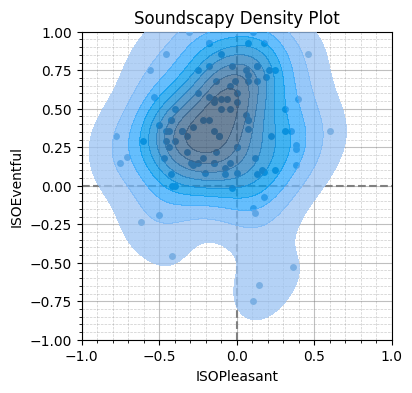

In [5]:
#| fig-cap: The figure shows the location of the Camden Town in London.
#| fig-align: center
sspy.plotting.density(
  df.query("LocationID == 'CamdenTown'"),
  figsize=(4, 4),
)

## Psychoacoustic Analysis {#sec-psychoacoustic}

**--- Expand here ---**

This has been optimised for performing batch processing of many recordings, ease of use, and reproducibility. To do this, we rely on three packages to provide the analysis functions:

- Python Acoustics (`acoustics`)^[It should be noted that the Github repo for python-acoustics has recently been archived and will no longer be actively developed by the original maintainer.] : Python Acoustics is a library aimed at acousticians. It provides two benefits - first, the analysis functions are referenced directly to the relevant standard. Second, Soundscapy subclasses the `Signal` class to provide the binaural functionality, and any function available within the `Signal` class is also available to Soundscapy's `Binaural` class. 
- scikit-maad @Ulloa2021scikit (`maad`) : scikit-maad is a modular toolbox for quantitative soundscape analysis, focused on ecological soundscapes and bioacoustic indices. scikit-maad provides a huge suite of ecosoundscape focused indices, including Acoustic Richness Index, Acoustic Complexity Index, Normalized Difference Soundscape Index, and more.
- MoSQITo (`mosqito`) : MoSQITo is a modular framework of key sound quality metrics, providing the psychoacoustic metrics for Soundscapy.


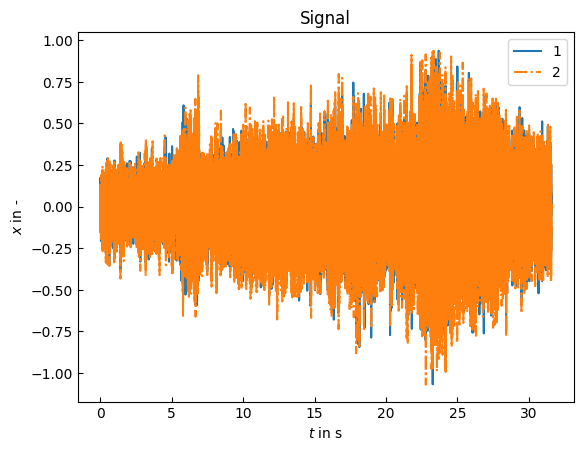

In [6]:
#| label: fig-binaural
#| fig-cap: Loading and viewing a binaural recording in Soundscapy.
#| fig-align: center
from soundscapy import Binaural
b = Binaural.from_wav(wav_dir.joinpath("CT101.wav"))
b.plot();

The metrics currently available are:

- Python Acoustics : $L_{Zeq}$, $L_{Aeq}$, $L_{Ceq}$, SEL, and all associated statistics ($L_5$ through $L_{95}$, $L_{max}$ and $L_{min}$, as well as kurtosis @Qiu2020Kurtosis and skewness).
- scikit-maad : So far, only the combined `all_temporal_alpha_indices` and `all_spectral_alpha_indices` functions from `scikit-maad` have been implemented; calculating them individually is not yet supported. `all_temporal_alpha_indices` comprises 16 temporal domain acoustic indices, such as temporal signal-to-noise ratio, temporal entropy, and temporal events. `all_spectra_alpha_indices` comprises 19 spectral domain acoustic indices, such as the Bioacoustic Index, Acoustic Diversity Index, NDSI, Acoustic Evenness Index, and Acoustic Complexity Index.
- MoSQITo : *cont.*

Soundscapy combines all of these metrics and makes it easy and (relatively) fast to compute any or all of them for a binaural audio recording. These results have been preliminarily validated through comparison of results obtained from Head Acoustics ArtemiS suite on a set of real-world recordings.

<!-- ```#show table.cell.where(x: 0): set text(style: "italic");```{=typst}
```#show table.cell.where(y: 0): set text(style: "normal", weight: "bold");```{=typst}
```#set table(stroke: (_, y) => if y > 0 { (top: 0.8pt) });```{=typst} -->

In [7]:
#| label: tbl-psycho
#| tbl-cap: Direct output of psychoacoustic metrics calculated by Soundscapy for a single binaural recording.
metric = "LAeq"
stats = ("avg", 10, 50, 90, 95, "max")
label = "LAeq"
res_df = b.pyacoustics_metric(metric, stats, label)
res_df.round(2)

LAeq  LAeq_10  LAeq_50  LAeq_90  LAeq_95  LAeq_max
Recording Channel                                                     
CT101     Left     68.89    71.16    68.12    63.39    62.38     77.39
          Right    69.96    72.58    68.50    64.54    63.10     78.71

### Consistent Analysis Settings

A primary goal when developing this library was to make it easy to save and document the settings used for all analyses. This is done through a `settings.yaml` file and the `AnalysisSettings` class. Although the settings for each metric can be set at runtime, the settings.yaml file allows you to set all of the settings at once and document exactly what settings were passed to each analysis function and to share these settings with collaborators or reviewers.

### Defining Analysis Settings

Soundscapy provides the ability to predefine the analysis settings. These are defined in a separate `.yaml` file and are managed by Soundscapy using the `AnalysisSettings` class. These settings can then be passed to any of the analysis functions, rather than separately defining your settings as we did above. This is particularly useful when performing batch processing on an entire folder of wav recordings.

Soundscapy provides a set of default settings which can be easily loaded in:


In [8]:
analysis_settings = sspy.AnalysisSettings.default()

and the settings file for the Loudness calculation can be printed:


In [9]:
analysis_settings['MoSQITo']['loudness_zwtv']

{'run': False,
 'main': 5,
 'statistics': [10, 50, 90, 95, 'min', 'max', 'kurt', 'skew', 'avg'],
 'channel': ['Left', 'Right'],
 'label': 'N',
 'parallel': True,
 'func_args': {'field_type': 'free'}}

These settings can then be passed to any of the analysis functions, like the following function which will calculate all of the metrics requested in the settings file:


In [ ]:
res_df = b.process_all_metrics(analysis_settings, verbose=False)

### Batch Processing

The other primary goal was to make it simple and fast to perform this analysis on many recordings. One aspect of this is unifying the outputs from the underlying libraries and presenting them in an easy to parse format. The analysis functions from Soundscapy can return a MultiIndex pandas DataFrame with the Recording filename and Left and Right channels in the index and a column for each metric calculated. This dataframe can then be easily saved to a .csv or Excel spreadsheet. Alternatively, a dictionary can be returned for further processing within Python. The key point is that after calculating 100+ metrics for 1,000+ recordings, you'll be left with a single tidy spreadsheet.

The Soundscape Indices (SSID) project for which this was developed has over 3,000 recordings for which we needed to calculate a full suite of metrics for both channels. In particular, the MoSQITo functions can be quite slow, so running each recording one at a time can be prohibitively slow and only utilize a small portion of the available computing power. To help with this, a set of simple functions is provided to enable parallel processing, such that multiple recordings can be processed simultaneously by a multi-core CPU. 


In [ ]:
#| include: false
#| echo: false
from soundscapy.analysis.binaural import prep_multiindex_df, add_results
import json
levels = wav_dir.joinpath("Levels.json")
with open(levels) as f:
  levels = json.load(f)
df = prep_multiindex_df(levels, incl_metric=False)

In [ ]:
#| label: serial-process
#| output: false
ser_start = time.perf_counter()
for wav in wav_dir.glob("*.wav"):
  recording = wav.stem
  decibel = tuple(levels[recording].values())
  b = Binaural.from_wav(wav, calibrate_to=decibel)
  ser_df = add_results(df, b.process_all_metrics(analysis_settings, verbose=False))
ser_end = time.perf_counter()

In [ ]:
#| output: false
#| label: parallel-process
#| fig-cap: Batch processing of 10 recordings using Soundscapy's parallel processing function.
par_start = time.perf_counter()
par_df = parallel_process(
  wav_dir.glob("*.wav"), df, levels, analysis_settings, verbose=False)
par_end = time.perf_counter()

In [ ]:
#| echo: false
#| output: asis
# print(f"Time taken for serial processing: {(ser_end - ser_start)/60:.2f} min")
# print(f"Time taken for parallel processing: {(par_end - par_start)/60:.2f} min")
# print(f"Speedup: {(ser_end - ser_start)/(par_end - par_start):.2f} times.")
from IPython.display import Markdown
ser_time = (ser_end - ser_start)
par_time = (par_end - par_start)
Markdown(f"Tested on a Macbook Pro M2 Max, processing 20 recordings (total of 10 minutes, 41 seconds of audio) in series took {ser_time/60:.1f} minutes, while processing the same 20 recordings in parallel took {par_time/60:.1f} minutes, a speed up of {ser_time / par_time:.1f} times.")



# Future development

In addition to continuing to improve the core functionality of Soundscapy, there are several areas where future development will be focused. Primarily, we aim to develop and integrate predictive soundscape models, which will allow us to predict the soundscape quality of a location based on its acoustic characteristics @Mitchell2023conceptual. This will involve developing machine learning models that can predict soundscape quality based on acoustic features, such as sound levels, frequency content, and temporal patterns. 

![Future development plans for Soundscapy](Soundscapy2.png){#fig-future width=100%}

# Conclusions

More information, including in depth tutorials, can be found in the Soundscapy documentation at [https://soundscapy.readthedocs.io/en/latest/](https://soundscapy.readthedocs.io/en/latest/).


# Acknowledgements {.unnumbered}
